In [30]:
import open3d as o3d
pc = o3d.io.read_point_cloud("/mnt/cc7c68c6-c81c-401d-91fd-04c40177514b/ScannedObjects/Mens_Authentic_Original_Boat_Shoe_in_Navy_Leather_xgoEcZtRNmH/Point_cloud/PCNBV/Iteraxxtra2/cloud_acc.pcd")
print(pc)

PointCloud with 61187 points.


In [31]:
o3d.visualization.draw_geometries([pc])

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_spherical_points(r, theta, phi, title="Puntos en coordenadas esféricas"):
    """
    Grafica puntos definidos en coordenadas esféricas (3D polares).

    Parámetros:
    - r: lista o array de radios
    - theta: lista o array de ángulos azimutales (en radianes, 0 a 2π)
    - phi: lista o array de ángulos polares (en radianes, 0 a π)
    """
    if not (len(r) == len(theta) == len(phi)):
        raise ValueError("r, theta y phi deben tener la misma longitud.")

    # Conversión a coordenadas cartesianas
    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)

    # Plot 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='red', s=50)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    plt.show()



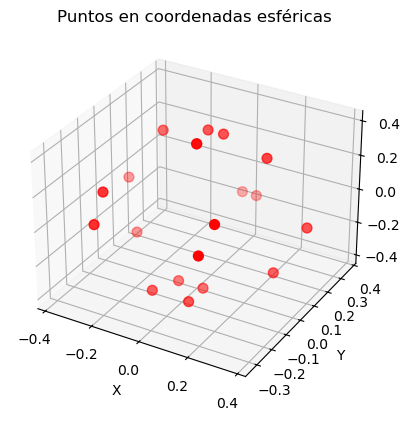

In [2]:
# Ángulos en radianes
alpha = .025
theta = np.linspace(0, 2 * np.pi/alpha, 20)
phi = np.linspace(0,(np.pi/2)/alpha,20)
# Radios aleatorios
r = np.full(20,.4)

plot_spherical_points(r, theta, phi)


In [2]:
import torch

def sample_on_sphere_surface_near_point(p, R=1.0, angle_limit=torch.pi/4, n=100, device="cpu", dtype=torch.float32):
    """
    Genera puntos en la superficie de una esfera de radio R, cerca del punto p (también sobre la esfera),
    limitados a un casquete esférico centrado en p con apertura angle_limit.

    Parámetros:
    - p: punto (tensor de forma (3,)) sobre la esfera
    - R: radio de la esfera madre (se normaliza p a este radio si es necesario)
    - angle_limit: ángulo de apertura (por ejemplo, π/4 para 45°)
    - n: número de puntos
    """
    p = torch.tensor(p, device=device, dtype=dtype)
    p_unit = p / torch.norm(p)  # Asegura que p esté sobre la esfera

    # Muestreo en casquete alrededor de +z
    theta = torch.rand(n, device=device, dtype=dtype) * 2 * torch.pi
    u = torch.rand(n, device=device, dtype=dtype)
    cos_min = torch.cos(torch.tensor(angle_limit, device=device, dtype=dtype))
    cos_phi = torch.lerp(cos_min, torch.tensor(1.0, device=device, dtype=dtype), u)
    phi = torch.acos(cos_phi)

    x = torch.sin(phi) * torch.cos(theta)
    y = torch.sin(phi) * torch.sin(theta)
    z = torch.cos(phi)
    points_local = torch.stack((x, y, z), dim=1)  # (n, 3)

    # 2. Rotar (+z) → p_unit
    def rotation_matrix_from_a_to_b(a, b):
        a = a / torch.norm(a)
        b = b / torch.norm(b)
        v = torch.linalg.cross(a, b)
        s = torch.norm(v)
        c = torch.dot(a, b)
        if s < 1e-8:
            return torch.eye(3, device=device, dtype=dtype) if c > 0 else -torch.eye(3, device=device, dtype=dtype)
        vx = torch.tensor([[0, -v[2], v[1]],
                           [v[2], 0, -v[0]],
                           [-v[1], v[0], 0]], device=device, dtype=dtype)
        R = torch.eye(3, device=device, dtype=dtype) + vx + vx @ vx * ((1 - c) / (s ** 2))
        return R

    Rmat = rotation_matrix_from_a_to_b(torch.tensor([0.0, 0.0, 1.0], device=device, dtype=dtype), p_unit)
    points_rotated = points_local @ Rmat.T

    # 3. Escalar por R (longitud fija)
    return points_rotated * R

def uniform_sample_on_sphere_surface_near_point(p, R=1.0, angle_limit=torch.pi/4, n=100, device="cpu", dtype=torch.float32):
    """
    Genera puntos en la superficie de una esfera de radio R, cerca del punto p (también sobre la esfera),
    limitados a un casquete esférico centrado en p con apertura angle_limit.

    Parámetros:
    - p: punto (tensor de forma (3,)) sobre la esfera
    - R: radio de la esfera madre (se normaliza p a este radio si es necesario)
    - angle_limit: ángulo de apertura (por ejemplo, π/4 para 45°)
    - n: número de puntos
    """
    p = torch.tensor(p, device=device, dtype=dtype)
    p_unit = p / torch.norm(p)  # Asegura que p esté sobre la esfera

    # Muestreo en casquete alrededor de +z
    theta = torch.empty(n).uniform_(0,2*torch.pi)
    u = torch.empty(n).uniform_(0,1)
    cos_min = torch.cos(torch.tensor(angle_limit, device=device, dtype=dtype))
    cos_phi = torch.lerp(cos_min, torch.tensor(1.0, device=device, dtype=dtype), u)
    phi = torch.acos(cos_phi)

    x = torch.sin(phi) * torch.cos(theta)
    y = torch.sin(phi) * torch.sin(theta)
    z = torch.cos(phi)
    points_local = torch.stack((x, y, z), dim=1)  # (n, 3)

    # 2. Rotar (+z) → p_unit
    def rotation_matrix_from_a_to_b(a, b):
        a = a / torch.norm(a)
        b = b / torch.norm(b)
        v = torch.linalg.cross(a, b)
        s = torch.norm(v)
        c = torch.dot(a, b)
        if s < 1e-8:
            return torch.eye(3, device=device, dtype=dtype) if c > 0 else -torch.eye(3, device=device, dtype=dtype)
        vx = torch.tensor([[0, -v[2], v[1]],
                           [v[2], 0, -v[0]],
                           [-v[1], v[0], 0]], device=device, dtype=dtype)
        R = torch.eye(3, device=device, dtype=dtype) + vx + vx @ vx * ((1 - c) / (s ** 2))
        return R

    Rmat = rotation_matrix_from_a_to_b(torch.tensor([0.0, 0.0, 1.0], device=device, dtype=dtype), p_unit)
    points_rotated = points_local @ Rmat.T

    # 3. Escalar por R (longitud fija)
    return points_rotated * R

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necesario aunque no se use directamente

def plot_points_3d(points, sphere_radius=None, sphere_center=None, title="Puntos 3D", elev=20, azim=45):
    """
    Grafica un conjunto de puntos 3D. Opcionalmente muestra una esfera base.

    Parámetros:
    - points: tensor (n, 3) con coordenadas [x, y, z]
    - sphere_radius: si se proporciona, dibuja una esfera con este radio
    - sphere_center: centro de la esfera, por defecto [0, 0, 0]
    - title: título de la gráfica
    - elev, azim: ángulos de vista en la gráfica 3D
    """
    import numpy as np

    points_np = points.detach().cpu().numpy()
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Puntos
    ax.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2], c='blue', s=10, alpha=0.6)

    # Esfera base (opcional)
    if sphere_radius is not None:
        center = sphere_center if sphere_center is not None else [0, 0, 0]
        u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
        x = sphere_radius * np.cos(u) * np.sin(v) + center[0]
        y = sphere_radius * np.sin(u) * np.sin(v) + center[1]
        z = sphere_radius * np.cos(v) + center[2]
        ax.plot_wireframe(x, y, z, color="gray", alpha=0.2, linewidth=0.5)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)
    ax.view_init(elev=elev, azim=azim)
    ax.set_box_aspect([1, 1, 1])
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_740829/94083249.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p = torch.tensor(p, device=device, dtype=dtype)


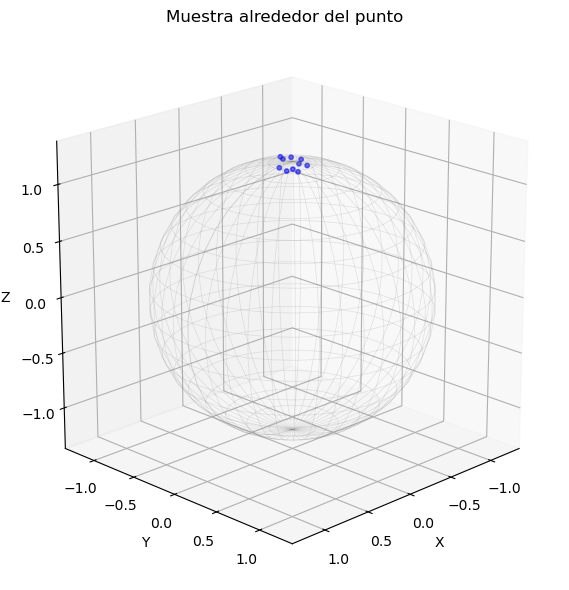

In [13]:
p = torch.tensor([0.0, 0.0, 0.4])
points = uniform_sample_on_sphere_surface_near_point(p, R=1.2, angle_limit=torch.pi/16, n=10)
plot_points_3d(points, sphere_radius=1.2, sphere_center=[0, 0, 0], title="Muestra alrededor del punto")

In [12]:
p.shape[0]

3

In [58]:
points.shape[0]

1

In [12]:
x = torch.tensor([0.0]).uniform_(-.4,.4)

In [13]:
x

tensor([0.1581])

In [32]:
torch.empty(1).uniform_(0,2*torch.pi)

tensor([0.4128])

In [1]:
from utils.reconstructorParams import Params

In [2]:
file = Params("dataexample/paramsAET.yaml")

In [3]:
file.getParameter("variables.angle_values")[0]

20

In [5]:
file.getParameter("carpetas.iter")+"_"+str(file.getParameter("variables.angle_values")[0])+"/"

'Iteraxnoise_20/'

In [7]:
for i in file.getParameter("variables.angle_values"):
    print(file.getParameter("carpetas.iter")+"_"+str(i)+"/")
    print(type(i))

Iteraxnoise_20/
<class 'int'>


In [3]:
import torch


In [4]:
torch.pi

3.141592653589793

In [ ]:
file.getParameter("variables.angle_values")[0]

20.0

In [1]:
import numpy as np

In [2]:
poses = np.loadtxt("/mnt/6C24E28478939C77/Saulo/vpl_python/stuff/pcnbv/viewspace_shapenet_33_normal.txt") #np.load("stuff/poses.npy")

In [3]:
poses.shape

(162, 3)

In [4]:
poses[1]

array([0.26286556, 0.16245985, 0.95105652])

In [5]:
len(poses)

162

In [3]:

rng = np.random.default_rng()

# Generar 10 valores entre [a, b)
a, b = 0, 156
valores = rng.integers(a, b)

print(valores)

81


In [11]:
poses[len(poses)-1]

array([ 0.        , -0.29524181, -0.95542256])

In [ ]:
np.random.default_rng()

150.14762589684253